In [49]:
# Install required libraries
!pip install transformers

In [1]:
# Define path to data
cha_path = '/kaggle/input/PittCombined8class/cha'

In [2]:
# Import necessary libraries
import os
import pandas as pd
from transformers import BertTokenizer, BertModel

In [3]:
# List files in directory
cha_files = [os.path.join(cha_path, file) for file in os.listdir(cha_path) if file.endswith('.cha')]
print(f"Found {len(cha_files)} CHA files.")

Found 1254 CHA files.


In [4]:
import re
import random
from collections import defaultdict, Counter

In [5]:
def extract_diagnosis(cha_file):
    """Extracts the diagnosis from a CHAT transcript file."""
    with open(cha_file, 'r') as file:
        content = file.read()
    match = re.search(r'@ID:\s*[^|]*\|[^|]*\|[^|]*\|[^|]*\|[^|]*\|([^|]*)\|', content)
    return match.group(1) if match else None

In [6]:
# Load all CHA files and their diagnoses
diagnoses = [extract_diagnosis(f) for f in cha_files]

In [7]:
# Group files by diagnosis
files_by_diagnosis = defaultdict(list)
for cha_file, diag in zip(cha_files, diagnoses):
    files_by_diagnosis[diag].append(cha_file)

In [8]:
# Select up to 500 files, trying to balance across diagnoses
selected_files = []
for diag, files in files_by_diagnosis.items():
    if len(files) >= 10:
        selected_files.extend(random.sample(files, min(len(files), max(500 // len(files_by_diagnosis), 10))))
selected_files = random.sample(selected_files, min(500, len(selected_files)))

In [9]:
selected_diagnoses = [extract_diagnosis(f) for f in selected_files]
diagnosis_count = Counter(selected_diagnoses)
print("Diagnosis counts:", dict(diagnosis_count))

Diagnosis counts: {'PossibleAD': 62, 'Memory': 12, 'MCI': 62, 'ProbableAD': 62, 'Control': 62, 'Vascular': 19}


In [10]:
from transformers import BertTokenizer, BertModel

# Initialize Clinical BERT
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
def preprocess_text(file_path):
    """Extracts text embeddings from a file using BioBERT."""
    with open(file_path, 'r') as file:
        text = file.read()
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    outputs = model(**inputs)
    return outputs.last_hidden_state.squeeze().mean(dim=0).detach().numpy()

In [12]:
# Process each file
text_embeddings = [preprocess_text(f) for f in selected_files]

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
# Convert list to numpy arrays
text_features = np.array(text_embeddings)

In [15]:
# Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(text_features)

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(selected_diagnoses)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2024-08-22 00:09:37.618254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 00:09:37.618387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 00:09:37.778808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [19]:
num_classes = len(np.unique(encoded_labels))

from tensorflow.keras.regularizers import l2

# Model architecture
input_layer = Input(shape=(768,))  # Adjust input shape to match the output of BioBERT
dense_layer = Dense(128, activation='relu',kernel_regularizer=l2(0.1))(input_layer)
batch_norm_layer = BatchNormalization()(dense_layer)
dropout_layer = Dropout(0.5)(batch_norm_layer)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])


In [21]:
# Fit model on training data
history = model.fit(X_train, to_categorical(y_train, num_classes=num_classes), validation_data=(X_val, to_categorical(y_val, num_classes=num_classes)), epochs=100, batch_size=32)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - Precision: 0.2660 - Recall: 0.1524 - accuracy: 0.2534 - loss: 23.9306 - val_Precision: 0.3659 - val_Recall: 0.2679 - val_accuracy: 0.3571 - val_loss: 22.3791
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.4877 - Recall: 0.3343 - accuracy: 0.4656 - loss: 21.6599 - val_Precision: 0.3696 - val_Recall: 0.3036 - val_accuracy: 0.3393 - val_loss: 21.0015
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.4704 - Recall: 0.2878 - accuracy: 0.3540 - loss: 19.9772 - val_Precision: 0.4250 - val_Recall: 0.3036 - val_accuracy: 0.3393 - val_loss: 19.4292
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Precision: 0.5084 - Recall: 0.3903 - accuracy: 0.4902 - loss: 18.2934 - val_Precision: 0.3864 - val_Recall: 0.3036 - val_accuracy: 0.3214 - val_loss: 17.8078
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - Precision: 0.5971 - Recall: 0.4530 - accuracy: 0.5680 - loss: 16.5362 - val_Precision: 0.4146 - val_Recall: 

In [22]:
# Evaluate the model
evaluation = model.evaluate(X_test, to_categorical(y_test, num_classes=num_classes))
print(f'Accuracy: {evaluation[1]*100:.2f}%, Precision: {evaluation[2]*100:.2f}%, Recall: {evaluation[3]*100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.4261 - Recall: 0.3542 - accuracy: 0.4107 - loss: 2.6981 
Accuracy: 42.86%, Precision: 44.68%, Recall: 37.50%


In [23]:
from sklearn.metrics import classification_report

# Predict classes on the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(to_categorical(y_test, num_classes=num_classes), axis=1)

# Calculate per-class accuracy, precision, and recall
report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
print(report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
              precision    recall  f1-score   support

     Control       0.52      0.85      0.65        13
         MCI       0.12      0.08      0.10        12
      Memory       0.00      0.00      0.00         2
  PossibleAD       0.54      0.54      0.54        13
  ProbableAD       0.45      0.42      0.43        12
    Vascular       0.00      0.00      0.00         4

    accuracy                           0.43        56
   macro avg       0.27      0.31      0.29        56
weighted avg       0.37      0.43      0.39        56



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


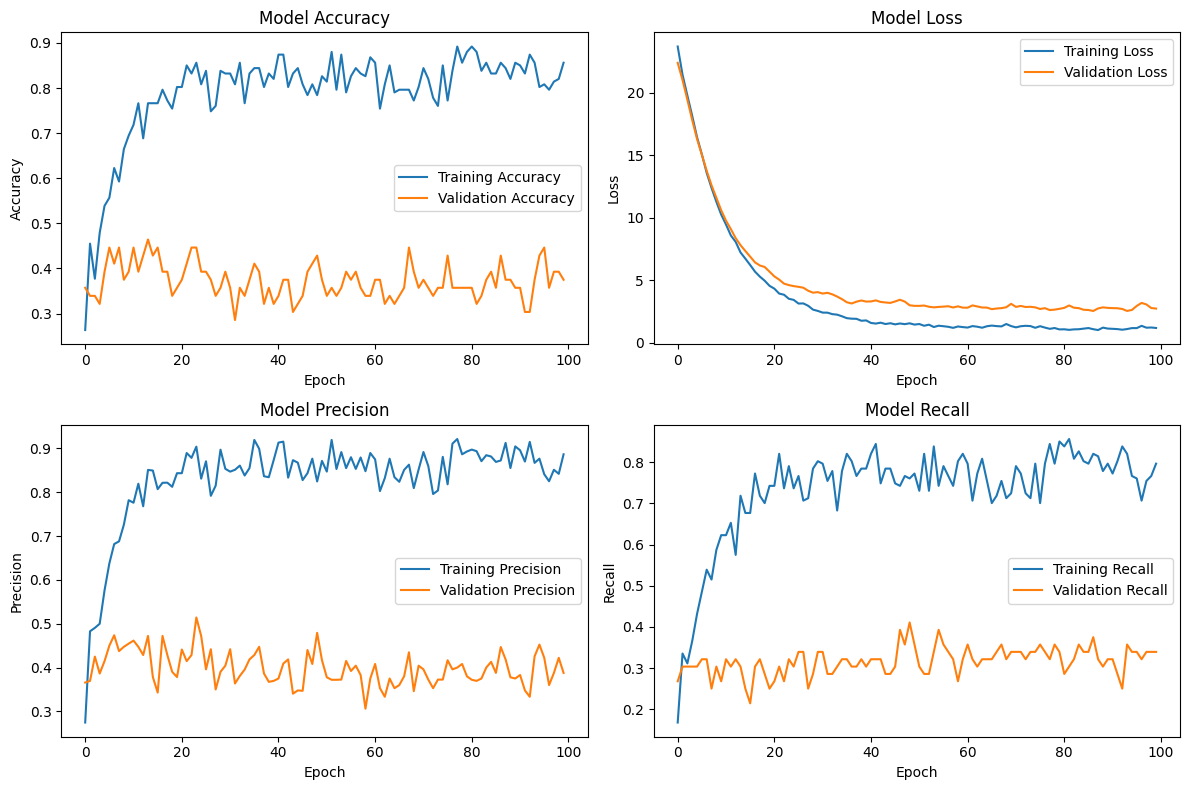

In [24]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that stores the history returned by the model.fit() method
def plot_training_history(history):
    # Plotting accuracy
    plt.figure(figsize=(12, 8))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(history.history['Precision'], label='Training Precision')
    plt.plot(history.history['val_Precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['Recall'], label='Training Recall')
    plt.plot(history.history['val_Recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have trained the model with:
# history = model.fit(...)
# Call the function to plot
plot_training_history(history)


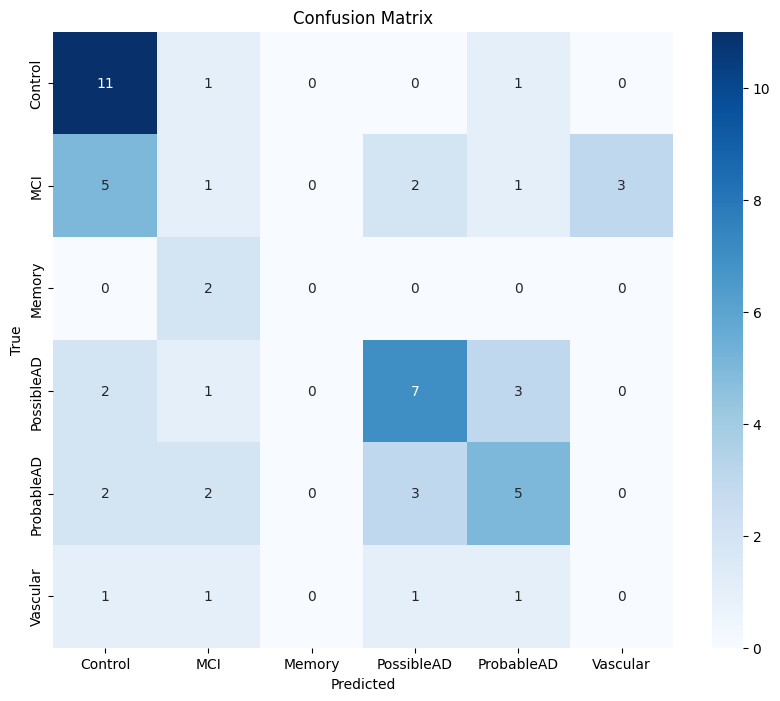

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'y_test' are the true labels and 'predicted_classes' are the predicted labels
def plot_confusion_matrix(y_test, predicted_classes, class_names):
    cm = confusion_matrix(y_test, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
class_names = label_encoder.classes_  # Assuming you have a label encoder used for your classes
plot_confusion_matrix(true_classes, predicted_classes, class_names)


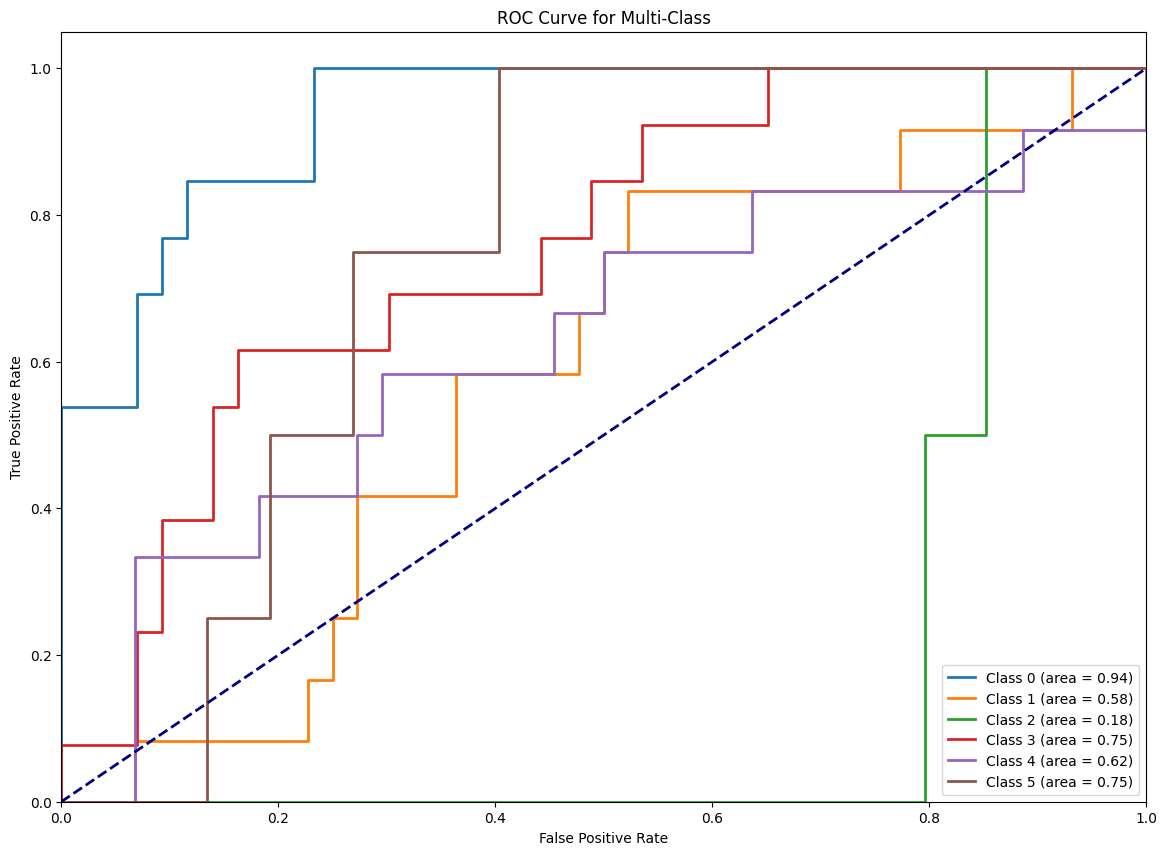

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=np.arange(num_classes))

def plot_roc_curves(y_test_binarized, predictions, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(14, 10))
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
plot_roc_curves(y_test_binarized, predictions, num_classes)


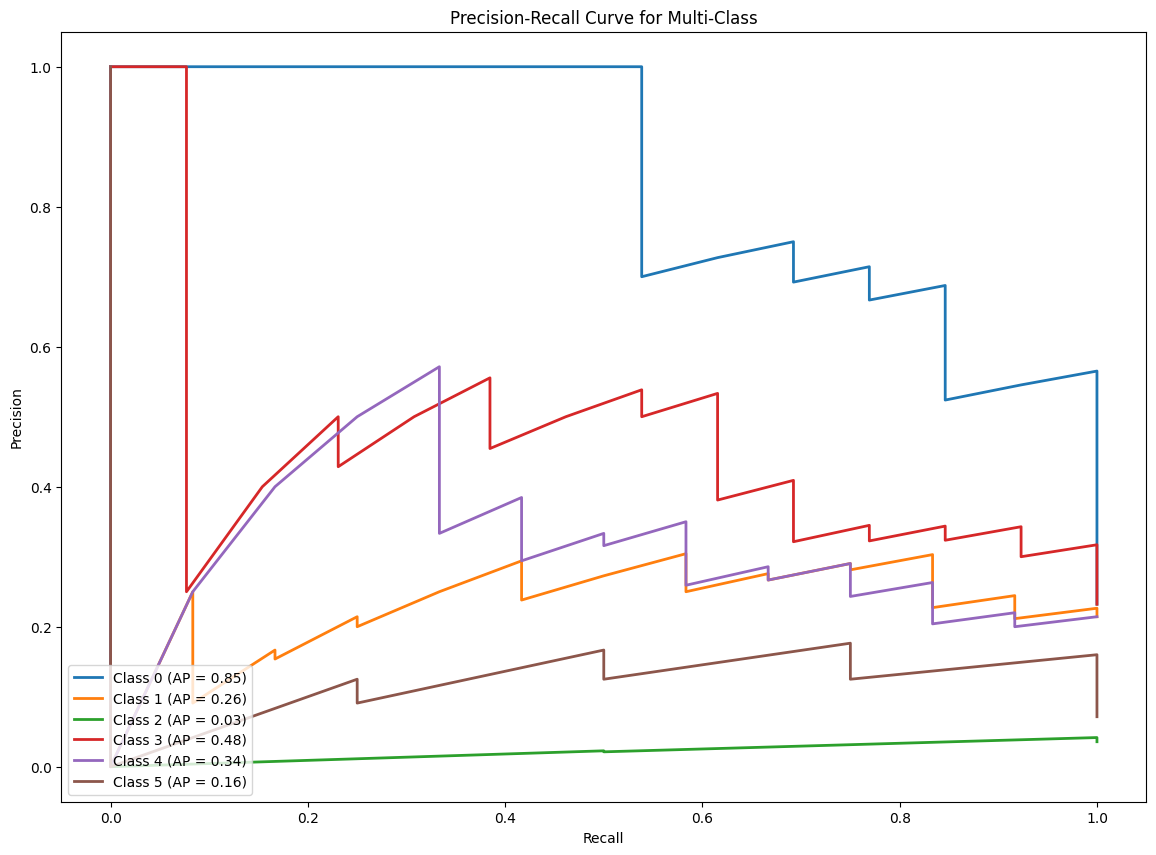

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def plot_precision_recall_curves(y_test_binarized, predictions, num_classes):
    plt.figure(figsize=(14, 10))
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], predictions[:, i])
        average_precision = average_precision_score(y_test_binarized[:, i], predictions[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multi-Class')
    plt.legend(loc="lower left")
    plt.show()

# Example usage:
plot_precision_recall_curves(y_test_binarized, predictions, num_classes)
